In [ ]:
# Merge All Data Jupyter Notebook

In [3]:
%matplotlib inline
# Imports
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#import matplotlib

import pandas as pd
import numpy as np
import durationpy
import math
from os.path import join
from collections import defaultdict
from statistics import mean 
import json

In [4]:
# Colors and others
pd.set_option('display.max_rows', 1000)
plt.style.use('ggplot')
COLORS_DEFAULT ={'blue': '#348ABD', 'red': '#EC9989'}

In [5]:
# Constants
CSV_RESULT_DIR = "../benchmark_results_data"

CPU_INFO_FILE = "cpuinfo.txt"

EVM_RESULT_FILE = "evm_benchmarks.csv"
STANDALONE_WASM_RESULT_FILE = "standalone_wasm_results.csv"
NATIVE_RESULT_FILE = "native_benchmarks.csv"
#SCOUT_RESULT_FILE = "scout_bignum_benchmarks.csv"


In [6]:
# Helpers

def toApropUnit(secs):
    if secs < 0.001:
        μs = secs * 1000000
        return "{}μs".format(round(μs, 1))
    if secs < 1 and secs >= 0.001:
        ms = secs * 1000
        return "{}ms".format(round(ms, 1))

def msToSec(ms):
    return ms / 1000

def sToSec(s):
    return s

# Read CSV Function
def read_results(file_name):
    results = defaultdict(list)
    csv_results = pd.read_csv(file_name)
    return csv_results

def filter_based_on_engine(df, e):
    df_data_filtered=df.copy()
    df_data_filtered=df_data_filtered[df_data_filtered.engine.eq(e)] if e else df_data_filtered
    df_data_filtered=df_data_filtered.reset_index(drop=True)
    df_data_filtered
    return df_data_filtered

def filter_by_averaging_string(df, s):
    l = lambda x: mean( [float(y) for y in x.split(', ')] )
    df_data_filtered = df.copy()
    df_data_filtered[s] = df[s].apply(l)
    return df_data_filtered

def filter_by_converting_time(df, f, s):
    df_data_filtered = df.copy()
    df_data_filtered[""+s] = df_data_filtered[""+s].apply(f)
    return df_data_filtered

def filename_by_virtualisation_type(t):
    return EVM_RESULT_FILE if t=='evm' else (STANDALONE_WASM_RESULT_FILE if t=='wasm' else NATIVE_RESULT_FILE)

def fix_test_name(t, ttype):
    if ttype=='evm':
        if t=='bn128_mul-chfast2':
            return 'bn128_mul_weierstrudel-chfast2'
        if t=='bn128_mul-cdetrio2':
            return 'bn128_mul_weierstrudel-cdetrio2'
        return t
    return t


In [7]:
# Show cpuinfo txt
with open(join(CSV_RESULT_DIR, CPU_INFO_FILE), 'r') as cpuinfofile:
   [print(line.rstrip()) for line in cpuinfofile.readlines()]

model name	: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
cpu MHz		: 2600.000
model name	: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
cpu MHz		: 2600.000
model name	: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
cpu MHz		: 2600.000
model name	: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
cpu MHz		: 2600.000
model name	: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
cpu MHz		: 2600.000
model name	: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
cpu MHz		: 2600.000


In [8]:
# Filter
evmdata = read_results(join(CSV_RESULT_DIR, EVM_RESULT_FILE))
gethdata = filter_based_on_engine(evmdata, 'geth-evm')
gethdata = filter_by_converting_time(gethdata, sToSec, ' total_time')
paritydata = filter_based_on_engine(evmdata, 'parity-evm')
paritydata = filter_by_converting_time(paritydata, sToSec, ' total_time')

wasmalldata = read_results(join(CSV_RESULT_DIR, STANDALONE_WASM_RESULT_FILE))
wasmdata = filter_based_on_engine(wasmalldata, 'wasm3')
wasmdata = filter_by_converting_time(wasmdata, sToSec, 'exec_time')

nativealldata = read_results(join(CSV_RESULT_DIR, NATIVE_RESULT_FILE))
nativedata = filter_by_averaging_string(nativealldata, 'elapsed_times')


In [9]:
# SelectTest
test = [
    'bn128_mul_weierstrudel-chfast2', 'bn128_mul_weierstrudel-chfast2',
    'bn128_mul-chfast2', 'bn128_mul-chfast2'
]
test = [
    'bn128_mul_weierstrudel-cdetrio2', 'bn128_mul_weierstrudel-cdetrio2',
    'bn128_mul-cdetrio2', 'bn128_mul-cdetri'
]
test = ['blake2b-2805-bytes']*4
test = ['blake2b-5610-bytes']*4
test = ['blake2b-8415-bytes']*4

test = ['sha1-10808-bits']*4
test = ['sha1-21896-bits']*4
test = ['sha1-42488-bits']*4
geth_customtest = gethdata[gethdata[" test_name"].eq(test[0])]
parity_customtest = paritydata[paritydata[" test_name"].eq(test[1])]
wasm_customtest = wasmdata[wasmdata["test_name"].eq(test[2])]
native_customtest = nativedata[nativedata["test_name"].eq(test[3])]

geth_customtest_f = float(geth_customtest[" total_time"]);        geth_customtest = toApropUnit(geth_customtest_f)
parity_customtest_f = float(parity_customtest[" total_time"]);    parity_customtest = toApropUnit(parity_customtest_f)
wasm_customtest_f = mean(wasm_customtest["exec_time"].tolist());  wasm_customtest = toApropUnit(wasm_customtest_f)
native_customtest_f = float(native_customtest["elapsed_times"]);  native_customtest = toApropUnit(native_customtest_f)

print( test[0], ': \nGeth,Parity,Wasm3,Native(Rust)')
print( geth_customtest_f, parity_customtest_f, wasm_customtest_f, native_customtest_f, sep=',' )
print( geth_customtest, parity_customtest, wasm_customtest, native_customtest, sep=',' )
# wasm_customtest["exec_time"].tolist()


sha1-42488-bits : 
Geth,Parity,Wasm3,Native(Rust)
0.045514967999999996,0.17311552800000002,0.00113646,1.5551020408163265e-05
45.5ms,173.1ms,1.1ms,15.6μs


In [10]:
# FirstPlot
# plt.close('all')#; plt.figure()
# fig, (ax) = plt.subplots(1, 1, sharey=True, figsize=(13,9))
# vals = [geth_customtest_f,parity_customtest_f,wasm_customtest_f,native_customtest_f]
# annotates = [geth_customtest,parity_customtest,wasm_customtest,native_customtest]
# labels = ['Geth', 'Parity', 'Wasm3', 'NativeRust']
# y_pos = np.arange(len(vals))
# ax.set_yticklabels([1,2,3,4])
# plt.bar(y_pos, vals, align='center')
# plt.xticks(y_pos, labels)
# plt.ylabel('BenchmarkTime')
# plt.title('BenchmarkResults', color='gray')
# for i in range(len(ax.patches)):
#     p = ax.patches[i]
#     note = annotates[i]
#     ax.annotate(
#         note, (p.get_x()+p.get_width()/2, p.get_height()+0.001), ha='center'
#     )
# plt.show()


In [11]:
# FILTER:
# Avaliable tests: 'bn128_mul-chfast2','bn128_mul-cdetrio2'
#         'blake2b-2805-bytes','blake2b-5610-bytes','blake2b-8415-bytes'
#         'sha1-10808-bits','sha1-21896-bits','sha1-42488-bits'
# Engines available for EVM: 'geth-evm', 'parity-evm'
# Engines available for WASM (wasmalldata["engine"].unique()): 
#        'wagon', 'wabt', 'v8-liftoff', 'v8-turbofan', 'v8-interpreter',
#        'wasmtime', 'wavm', 'life-polymerase', 'life', 'wasmi',
#        'wamr-interp', 'wamr-jit', 'wamr-aot', 'wasm3'
# Engines available for NATIVE: 'native-rust'
# test = 'blake2b-2805-bytes'
# filters = [
#     { 'virtualisation_type':'evm',   'engine':'geth-evm','prefix':' ','column':'total_time' },
#     { 'virtualisation_type':'wasm',  'engine':'wasm3',   'prefix':'','column':'exec_time' },
#     { 'virtualisation_type':'native','engine':'',        'prefix':'','column':'elapsed_times' }
# ]
# customtest_f, customtest = [], []
# for i in range(len(filters)):
#     t = filters[i]['virtualisation_type']
#     e = filters[i]['engine']
#     c = filters[i]['column']
#     p = filters[i]['prefix']
#     RESULT_FILE = filename_by_virtualisation_type(t)
#     rawdata = read_results(join(CSV_RESULT_DIR, RESULT_FILE))
#     rawdata = filter_based_on_engine(rawdata,e)
#     edata = filter_by_converting_time(rawdata,sToSec,p+c) if e else rawdata
#     edata = filter_by_averaging_string(rawdata,p+c) if not e else edata
#     e_customtest_f = mean(edata[edata[p+"test_name"].eq(fix_test_name(test,t))][p+c].tolist())
#     e_customtest = toApropUnit(e_customtest_f)
#     customtest_f.append(e_customtest_f)
#     customtest.append(e_customtest)
# print('Test:', test, '\n', 'Virtualisations:')
# for i in range(len(filters)): print(filters[i]['virtualisation_type']+' ', end="")
# print('Engines')
# for i in range(len(filters)): print(filters[i]['engine']+' | ', end="")
# print('\n---')
# for i in range(len(customtest)): print(customtest[i]+'('+str(customtest_f[i])+''+' | ',end="")
# # Plot

# plt.close('all')#; plt.figure()
# fig, (ax) = plt.subplots(1, 1, sharey=True, figsize=(13,9))
# vals = customtest_f
# annotates = customtest
# labels = [f['virtualisation_type']+' '+f['engine'] for f in filters]
# y_pos = np.arange(len(vals))
# ax.set_yticklabels(np.arange(len(vals)))
# plt.bar(y_pos, vals, align='center')
# plt.xticks(y_pos, labels)
# plt.title('BenchmarkResults: '+test, color='gray')
# plt.xlabel('Smart Contract Types (Virtualisation)')
# plt.ylabel('Benchmark Results (Elipsed Time)')
# colors = [ # list('rgbkymc')
#     '#EC9989', '#90D1C2', '#90D1C2',
#     '#90D1C2', '#D1D191', '#EB65E5',
#     '#7DCBF5'
# ]
# for i in range(min(len(vals),len(colors))):
#     ax.get_children()[i].set_color(colors[i])
# for i in range(len(ax.patches)):
#     p = ax.patches[i]
#     note = annotates[i]
#     ax.annotate(note, (p.get_x()+p.get_width()/2, p.get_height()+0.001), ha='center')
# plt.show()


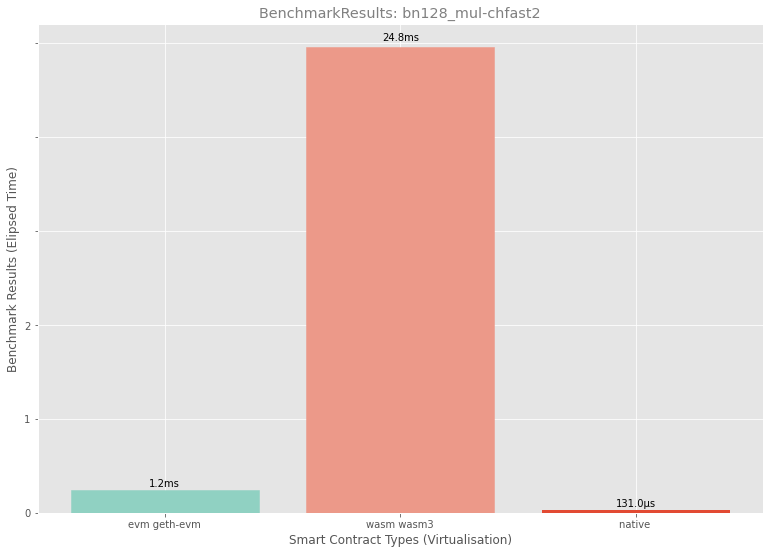

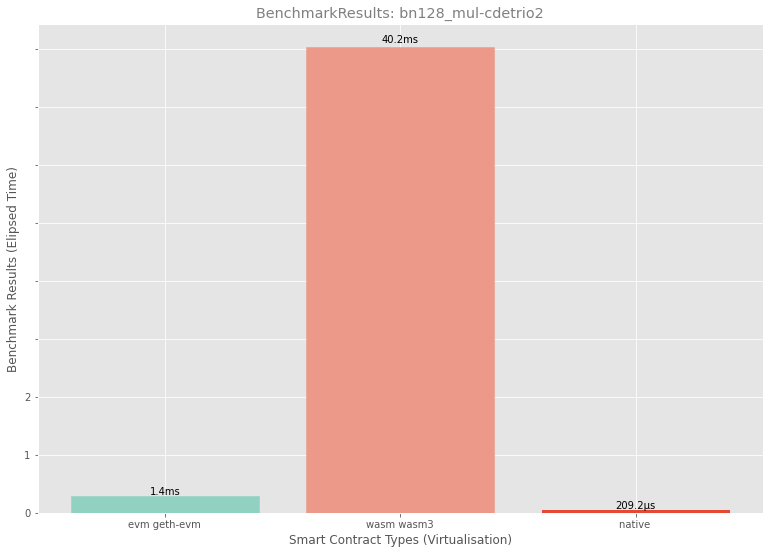

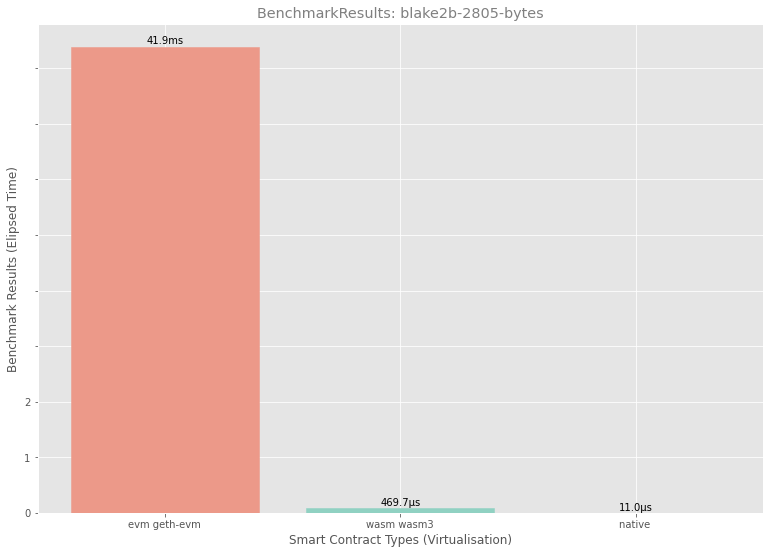

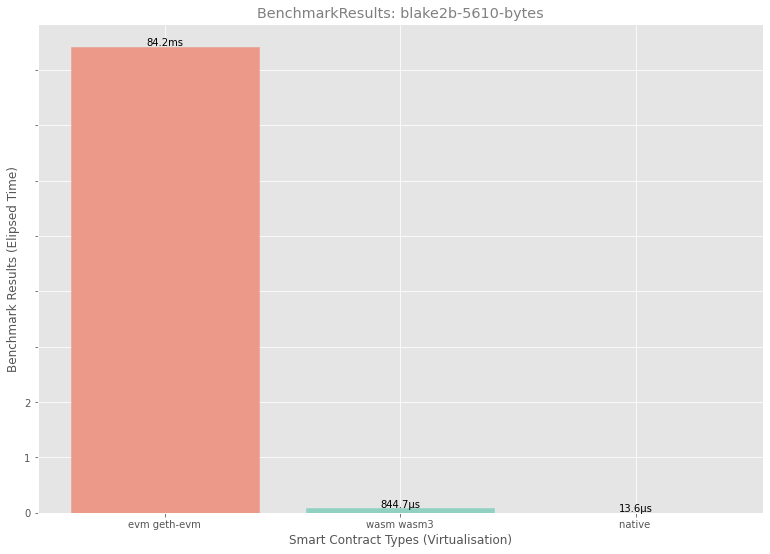

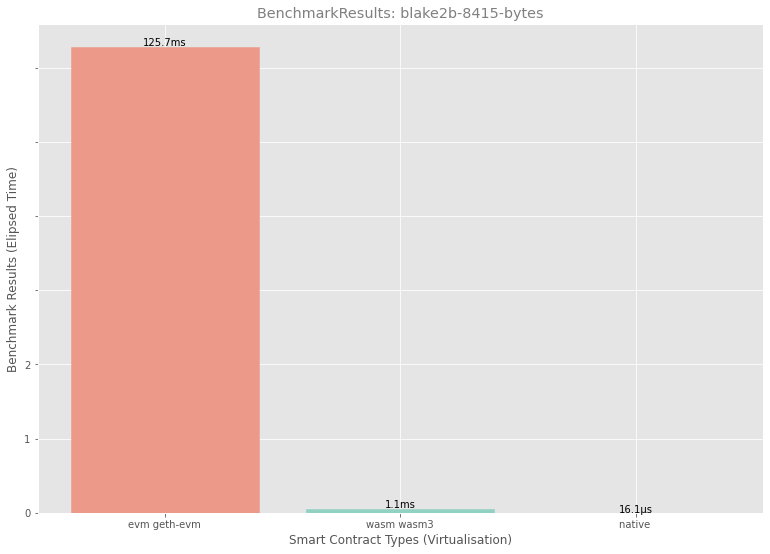

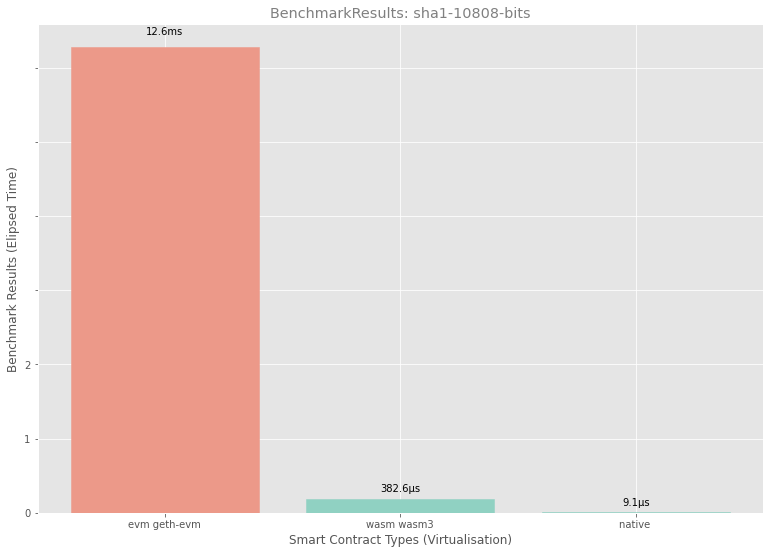

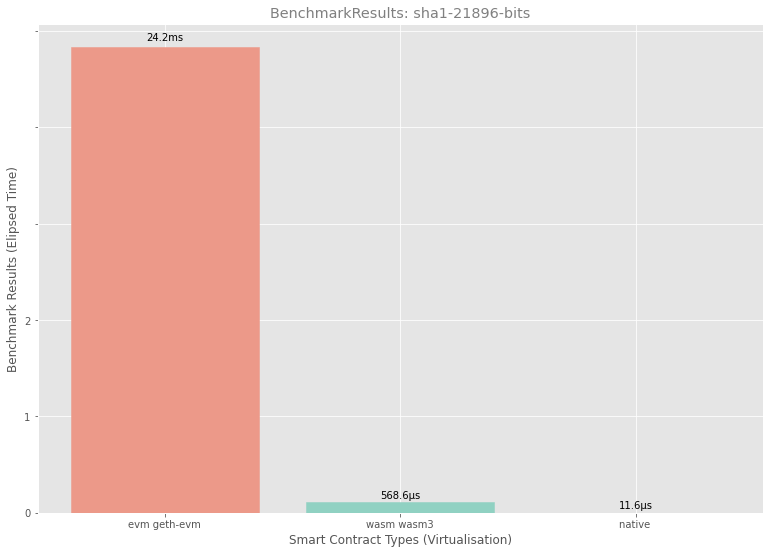

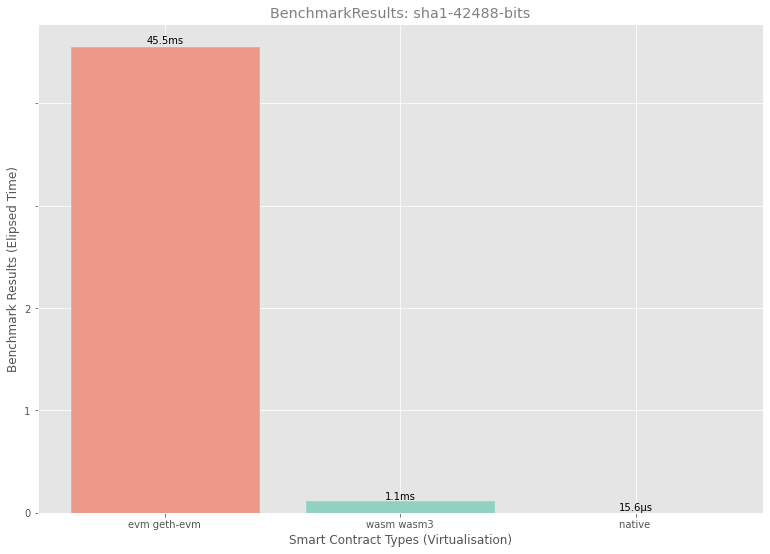

In [12]:
# All Tests
# FILTER:
# Avaliable tests: 'bn128_mul-chfast2','bn128_mul-cdetrio2'
#         'blake2b-2805-bytes','blake2b-5610-bytes','blake2b-8415-bytes'
#         'sha1-10808-bits','sha1-21896-bits','sha1-42488-bits'
# Engines available for EVM: 'geth-evm', 'parity-evm'
# Engines available for WASM (wasmalldata["engine"].unique()): 
#        'wagon', 'wabt', 'v8-liftoff', 'v8-turbofan', 'v8-interpreter',
#        'wasmtime', 'wavm', 'life-polymerase', 'life', 'wasmi',
#        'wamr-interp', 'wamr-jit', 'wamr-aot', 'wasm3'
# Engines available for NATIVE: 'native-rust'
def calc_customtest_by_test_and_filter(test, filters):
    customtest_f, customtest = [], []
    for i in range(len(filters)):
        t = filters[i]['virtualisation_type']
        e = filters[i]['engine']
        c = filters[i]['column']
        p = filters[i]['prefix']
        RESULT_FILE = filename_by_virtualisation_type(t)
        rawdata = read_results(join(CSV_RESULT_DIR, RESULT_FILE))
        rawdata = filter_based_on_engine(rawdata,e)
        edata = filter_by_converting_time(rawdata,sToSec,p+c) if e else rawdata
        edata = filter_by_averaging_string(rawdata,p+c) if not e else edata
        e_customtest_f = mean(edata[edata[p+"test_name"].eq(fix_test_name(test,t))][p+c].tolist())
        e_customtest = toApropUnit(e_customtest_f)
        customtest_f.append(e_customtest_f)
        customtest.append(e_customtest)
    return customtest_f, customtest

def plot_by_customtest_filters_n_test(customtest_f,customtest,filters,test,c=[]):
    plt.close('all')#; plt.figure()
    fig, (ax) = plt.subplots(1, 1, sharey=True, figsize=(13,9))
    vals = customtest_f
    annotates = customtest
    labels = [f['virtualisation_type']+' '+f['engine'] for f in filters]
    y_pos = np.arange(len(vals))
    ax.set_yticklabels(np.arange(len(vals)))
    plt.bar(y_pos, vals, align='center')
    plt.xticks(y_pos, labels)
    plt.title('BenchmarkResults: '+test, color='gray')
    plt.xlabel('Smart Contract Types (Virtualisation)')
    plt.ylabel('Benchmark Results (Elipsed Time)')
    if c == []:
        colors = [ # list('rgbkymc')
            '#EC9989', '#90D1C2', '#90D1C2',
            '#90D1C2', '#D1D191', '#EB65E5',
            '#7DCBF5'
        ]
    else:
        colors = c
    for i in range(min(len(vals),len(colors))):
        ax.get_children()[i].set_color(colors[i])
    for i in range(len(ax.patches)):
        p = ax.patches[i]
        note = annotates[i]
        if (vals[i]<0.004):
            h = vals[i]+0.00005
#             0.00005
        else:
            h = vals[i]+0.0002
        ax.annotate(note, (p.get_x()+p.get_width()/2, h+0.00015), ha='center')
    plt.show()

test = 'bn128_mul-chfast2'
filters = [
    {'virtualisation_type':'evm',   'engine':'geth-evm','prefix':' ','column':'total_time'},
    {'virtualisation_type':'wasm',  'engine':'wasm3',   'prefix':'','column':'exec_time'},
    {'virtualisation_type':'native','engine':'',        'prefix':'','column':'elapsed_times'}]
customtest_f, customtest = calc_customtest_by_test_and_filter(test, filters)
plot_by_customtest_filters_n_test(customtest_f,customtest,filters,test,['#90D1C2','#EC9989'])
test = 'bn128_mul-cdetrio2'
filters = [
    {'virtualisation_type':'evm',   'engine':'geth-evm','prefix':' ','column':'total_time'},
    {'virtualisation_type':'wasm',  'engine':'wasm3',   'prefix':'','column':'exec_time'},
    {'virtualisation_type':'native','engine':'',        'prefix':'','column':'elapsed_times'}]
customtest_f, customtest = calc_customtest_by_test_and_filter(test, filters)
plot_by_customtest_filters_n_test(customtest_f,customtest,filters,test,['#90D1C2','#EC9989'])

test = 'blake2b-2805-bytes'
filters = [
    {'virtualisation_type':'evm',   'engine':'geth-evm','prefix':' ','column':'total_time'},
    {'virtualisation_type':'wasm',  'engine':'wasm3',   'prefix':'','column':'exec_time'},
    {'virtualisation_type':'native','engine':'',        'prefix':'','column':'elapsed_times'}]
customtest_f, customtest = calc_customtest_by_test_and_filter(test, filters)
plot_by_customtest_filters_n_test(customtest_f,customtest,filters,test)
test = 'blake2b-5610-bytes'
filters = [
    {'virtualisation_type':'evm',   'engine':'geth-evm','prefix':' ','column':'total_time'},
    {'virtualisation_type':'wasm',  'engine':'wasm3',   'prefix':'','column':'exec_time'},
    {'virtualisation_type':'native','engine':'',        'prefix':'','column':'elapsed_times'}]
customtest_f, customtest = calc_customtest_by_test_and_filter(test, filters)
plot_by_customtest_filters_n_test(customtest_f,customtest,filters,test)
test = 'blake2b-8415-bytes'
filters = [
    {'virtualisation_type':'evm',   'engine':'geth-evm','prefix':' ','column':'total_time'},
    {'virtualisation_type':'wasm',  'engine':'wasm3',   'prefix':'','column':'exec_time'},
    {'virtualisation_type':'native','engine':'',        'prefix':'','column':'elapsed_times'}]
customtest_f, customtest = calc_customtest_by_test_and_filter(test, filters)
plot_by_customtest_filters_n_test(customtest_f,customtest,filters,test)

test = 'sha1-10808-bits'
filters = [
    {'virtualisation_type':'evm',   'engine':'geth-evm','prefix':' ','column':'total_time'},
    {'virtualisation_type':'wasm',  'engine':'wasm3',   'prefix':'','column':'exec_time'},
    {'virtualisation_type':'native','engine':'',        'prefix':'','column':'elapsed_times'}]
customtest_f, customtest = calc_customtest_by_test_and_filter(test, filters)
plot_by_customtest_filters_n_test(customtest_f,customtest,filters,test)
test = 'sha1-21896-bits'
filters = [
    {'virtualisation_type':'evm',   'engine':'geth-evm','prefix':' ','column':'total_time'},
    {'virtualisation_type':'wasm',  'engine':'wasm3',   'prefix':'','column':'exec_time'},
    {'virtualisation_type':'native','engine':'',        'prefix':'','column':'elapsed_times'}]
customtest_f, customtest = calc_customtest_by_test_and_filter(test, filters)
plot_by_customtest_filters_n_test(customtest_f,customtest,filters,test)
test = 'sha1-42488-bits'
filters = [
    {'virtualisation_type':'evm',   'engine':'geth-evm','prefix':' ','column':'total_time'},
    {'virtualisation_type':'wasm',  'engine':'wasm3',   'prefix':'','column':'exec_time'},
    {'virtualisation_type':'native','engine':'',        'prefix':'','column':'elapsed_times'}]
customtest_f, customtest = calc_customtest_by_test_and_filter(test, filters)
plot_by_customtest_filters_n_test(customtest_f,customtest,filters,test)


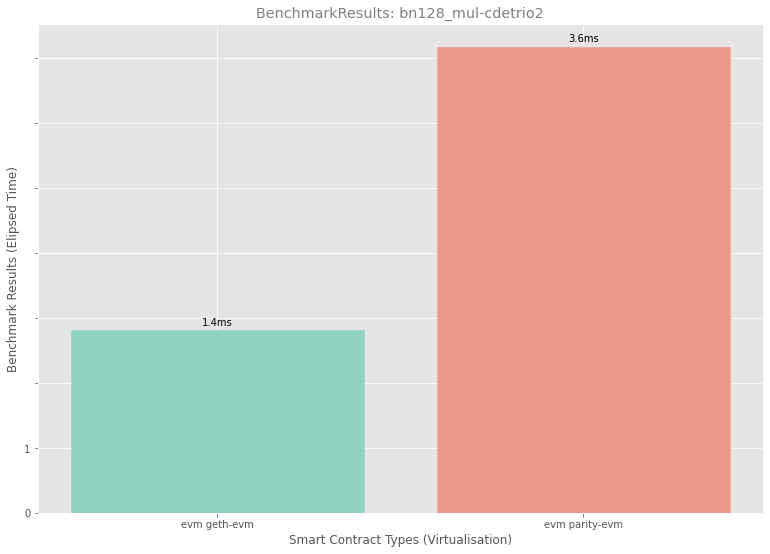

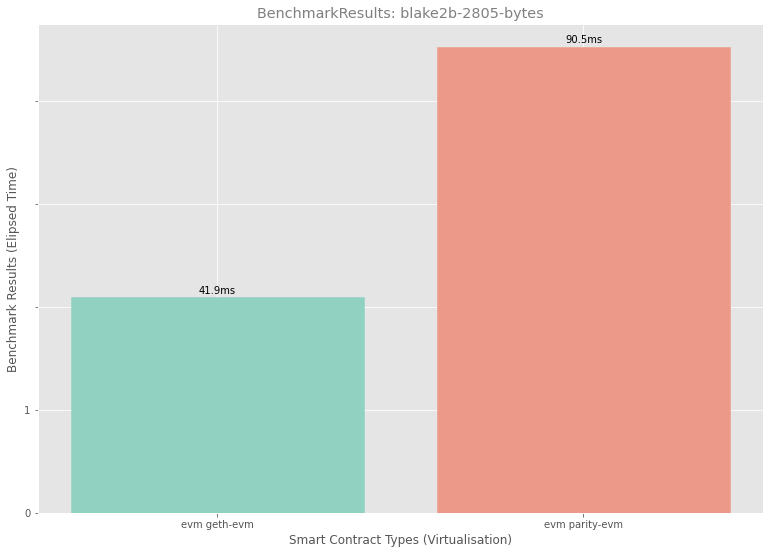

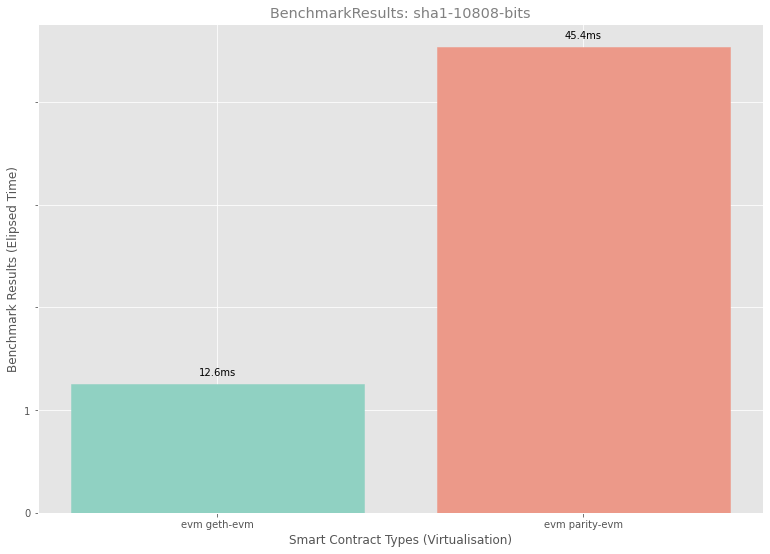

In [13]:
# Geth v Parity
def plot_by_customtest_filters_n_test(customtest_f,customtest,filters,test,c=list('rgbkymc')):
    plt.close('all')#; plt.figure()
    fig, (ax) = plt.subplots(1, 1, sharey=True, figsize=(13,9))
    vals = customtest_f
    annotates = customtest
    labels = [f['virtualisation_type']+' '+f['engine'] for f in filters]
    y_pos = np.arange(len(vals))
    ax.set_yticklabels(np.arange(len(vals)))
    plt.bar(y_pos, vals, align='center')
    plt.xticks(y_pos, labels)
    plt.title('BenchmarkResults: '+test, color='gray')
    plt.xlabel('Smart Contract Types (Virtualisation)')
    plt.ylabel('Benchmark Results (Elipsed Time)')
    colors = c
    for i in range(min(len(vals),len(colors))):
        ax.get_children()[i].set_color(colors[i])
    for i in range(len(ax.patches)):
        p = ax.patches[i]
        note = annotates[i]
        if (vals[i]<0.004):
            h = vals[i]+0.00005
        else:
            h = vals[i]+0.0008
        ax.annotate(note, (p.get_x()+p.get_width()/2, h-0.00001), ha='center')
    plt.show()

test = 'bn128_mul-cdetrio2'
filters = [
    {'virtualisation_type':'evm', 'engine':'geth-evm','prefix':' ','column':'total_time'},
    {'virtualisation_type':'evm', 'engine':'parity-evm','prefix':' ','column':'total_time'}]
customtest_f, customtest = calc_customtest_by_test_and_filter(test, filters)
plot_by_customtest_filters_n_test(customtest_f,customtest,filters,test,['#90D1C2','#EC9989'])

test = 'blake2b-2805-bytes'
filters = [
    {'virtualisation_type':'evm', 'engine':'geth-evm','prefix':' ','column':'total_time'},
    {'virtualisation_type':'evm', 'engine':'parity-evm','prefix':' ','column':'total_time'}]
customtest_f, customtest = calc_customtest_by_test_and_filter(test, filters)
plot_by_customtest_filters_n_test(customtest_f,customtest,filters,test,['#90D1C2','#EC9989'])

test = 'sha1-10808-bits'
filters = [
    {'virtualisation_type':'evm', 'engine':'geth-evm','prefix':' ','column':'total_time'},
    {'virtualisation_type':'evm', 'engine':'parity-evm','prefix':' ','column':'total_time'}]
customtest_f, customtest = calc_customtest_by_test_and_filter(test, filters)
plot_by_customtest_filters_n_test(customtest_f,customtest,filters,test,['#90D1C2','#EC9989'])


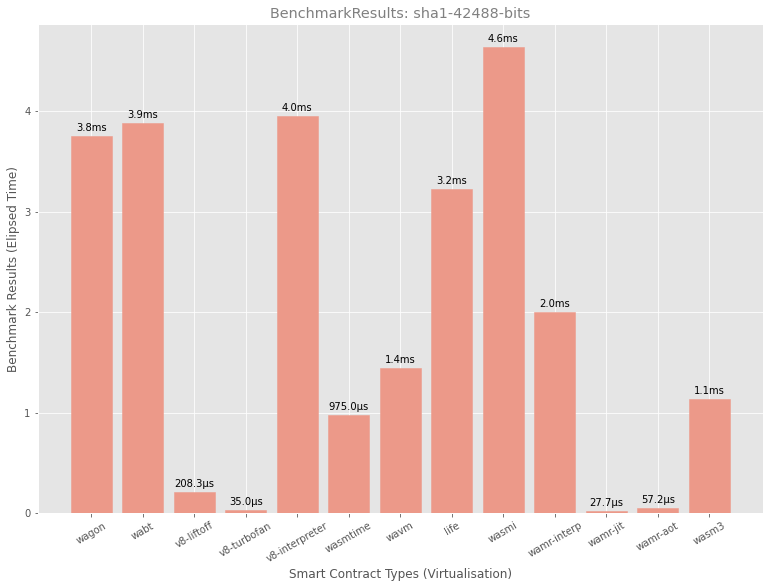

In [15]:
# Engines available for WASM (wasmalldata["engine"].unique()): 
test = 'bn128_mul-chfast2'
test = 'blake2b-8415-bytes'
test = 'sha1-42488-bits'
filters = [
    {'virtualisation_type':'wasm','engine':'wagon',   'prefix':'','column':'exec_time'},
    {'virtualisation_type':'wasm','engine':'wabt',    'prefix':'','column':'exec_time'},
    {'virtualisation_type':'wasm','engine':'v8-liftoff',   'prefix':'','column':'exec_time'},
    {'virtualisation_type':'wasm','engine':'v8-turbofan',   'prefix':'','column':'exec_time'},
    {'virtualisation_type':'wasm','engine':'v8-interpreter','prefix':'','column':'exec_time'},
    {'virtualisation_type':'wasm','engine':'wasmtime','prefix':'','column':'exec_time'},
    {'virtualisation_type':'wasm','engine':'wavm','prefix':'','column':'exec_time'},
    {'virtualisation_type':'wasm','engine':'life','prefix':'','column':'exec_time'},
    {'virtualisation_type':'wasm','engine':'wasmi','prefix':'','column':'exec_time'},
    {'virtualisation_type':'wasm','engine':'wamr-interp','prefix':'','column':'exec_time'},
    {'virtualisation_type':'wasm','engine':'wamr-jit','prefix':'','column':'exec_time'},
    {'virtualisation_type':'wasm','engine':'wamr-aot','prefix':'','column':'exec_time'},
    {'virtualisation_type':'wasm','engine':'wasm3','prefix':'','column':'exec_time'},
#     {'virtualisation_type':'wasm','engine':'life-polymerase','prefix':'','column':'exec_time'},
]
customtest_f, customtest = calc_customtest_by_test_and_filter(test, filters)
# plot_by_customtest_filters_n_test(customtest_f,customtest,filters,test,c)
plt.close('all')#; plt.figure()
fig, (ax) = plt.subplots(1, 1, sharey=True, figsize=(13,9))
vals = customtest_f
annotates = customtest
labels = [f['engine'] for f in filters]
y_pos = np.arange(len(vals))
ax.set_yticklabels(np.arange(len(vals)))
plt.bar(y_pos, vals, align='center')
plt.xticks(y_pos, labels, rotation=30)
plt.title('BenchmarkResults: '+test, color='gray')
plt.xlabel('Smart Contract Types (Virtualisation)')
plt.ylabel('Benchmark Results (Elipsed Time)')
colors = ['#EC9989']*13
for i in range(min(len(vals),len(colors))):
    ax.get_children()[i].set_color(colors[i])
for i in range(len(ax.patches)):
    p = ax.patches[i]
    note = annotates[i]
    ax.annotate(note, (p.get_x()+p.get_width()/2, vals[i]+0.00005), ha='center')
plt.show()


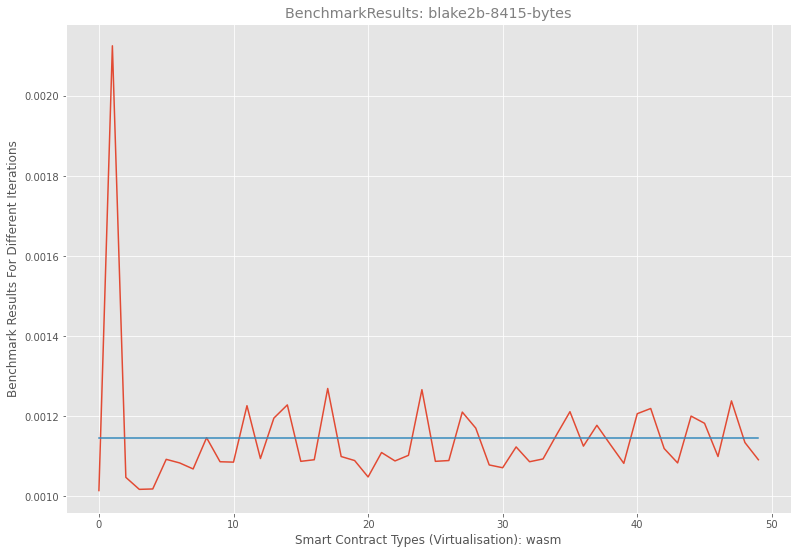

In [39]:
# Test accuracy
test = 'blake2b-8415-bytes'
# test = 'sha1-42488-bits'
filters = [{'virtualisation_type':'wasm','engine':'wasm3','prefix':'','column':'exec_time'}]
customtest_f, customtest = [], []
t = filters[0]['virtualisation_type']
e = filters[0]['engine']
c = filters[0]['column']
p = filters[0]['prefix']
RESULT_FILE = filename_by_virtualisation_type(t)
rawdata = read_results(join(CSV_RESULT_DIR, RESULT_FILE))
rawdata = filter_based_on_engine(rawdata,e)
edata = filter_by_converting_time(rawdata,sToSec,p+c)
e_customtest_detailed = edata[edata[p+"test_name"].eq(fix_test_name(test,t))][p+c]
e_customtest_mean = mean(edata[edata[p+"test_name"].eq(fix_test_name(test,t))][p+c].tolist())
plt.close('all')#; plt.figure()
fig, (ax) = plt.subplots(1, 1, sharey=True, figsize=(13,9))
vals = e_customtest_detailed
plt.plot(np.arange(len(vals)), vals)
vals2 = [e_customtest_mean]*50
plt.plot(np.arange(len(vals)), vals2)
plt.title('BenchmarkResults: '+test, color='gray')
plt.xlabel('Smart Contract Types (Virtualisation): '+t)
plt.ylabel('Benchmark Results For Different Iterations')
plt.show()